In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
with open('/data/weifan/lllt/profiling-Meta-Llama-3-8B-Instruct.json', 'r') as fin:
    instruction = json.load(fin)

records = instruction['records']

os.system('mkdir -p dataset/lllt')

0

In [3]:
records[1]

{'record_id': 0,
 'start_ts': '2024-06-27 14:55:33.616826',
 'record_prompt': '<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n',
 'output': '[RequestOutput(request_id=0, prompt="<|begin_of_text|><|start_header_id|>user<|end_header_id|>\\n\\n{\'Below is an instruction that describes a task. Write a response that appropriately completes the request. ### Instruction: Give three tips for staying healthy. ### Response:\'}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\\n\\n", prompt_token_ids=[128000, 128000, 128006, 882, 128007, 271, 13922, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 13, 17010, 30151, 25, 21335, 2380, 10631, 369, 19994, 9498, 13, 17010, 6075, 4989, 92, 128009, 128006, 78191, 128007, 271], prompt_logprobs=None, outputs=[CompletionOutput(index=0, text=\'Here are three tips for staying healthy:\\n\\n**1. Stay Hydrated**: Drinking plenty of water throughout the day is essential for maintaining healthy s

In [3]:
shape = 4096

for r in tqdm(records[1:]):
    id = r['record_id']

    if not os.path.isfile(f'dataset/lllt/{id}.npz'):
        iteration_count = r['iteration_count']

        last_layer_embedding = np.zeros((iteration_count - 1, shape), dtype=np.float32)
        remain_iter = np.zeros(iteration_count - 1, dtype=int)
        iterations = r['iterations']
        for idx, iter in enumerate(iterations[1:]):
            ts = iter['iter_ts']
            embedding_path = f'/data/weifan/lllt/llama_last_layer_tensor/{ts}+.pt'
            embedding = torch.load(embedding_path).detach().cpu().numpy().reshape((shape, ))
            last_layer_embedding[idx, :] = embedding
            remain_iter[idx] = iteration_count - 2 - idx
        
        np.savez_compressed(x=last_layer_embedding, y=remain_iter, file=f'dataset/lllt/{id}.npz')

  0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
def get_data_partition(by_prompt=True, train_size=0.8):

    fnames = sorted([x for x in os.listdir('dataset/lllt') if x.endswith('.npz')])
    Xs, Ys = list(), list()
    for fname in tqdm(fnames):
        dat = np.load(f'dataset/lllt/{fname}')
        Xs.append(dat['x'])
        Ys.append(dat['y'])
    
    if by_prompt:
        idxs = list(range(len(fnames)))
        train_p_idx, test_p_idx = train_test_split(idxs, train_size=train_size, random_state=10)

        X_train_test, Y_train_test = list(), list()
        prompts_train_test = list()
        for idx_list in [train_p_idx, test_p_idx]:
            X_train_test.append(np.concatenate([Xs[i] for i in idx_list], axis=0))
            Y_train_test.append(np.concatenate([Ys[i] for i in idx_list]))
            prompt_list = list()
            for i in idx_list:
                prompt_Ys = Ys[i]
                for y in prompt_Ys:
                    prompt_list.append((i, y))
            prompts_train_test.append(prompt_list)
        
        X_train, X_test = X_train_test
        Y_train, Y_test = Y_train_test
        prompts_train, prompts_test = prompts_train_test

        return X_train, Y_train, X_test, Y_test, prompts_train, prompts_test

In [20]:
X_train, Y_train, X_test, Y_test, prompts_train, prompts_test = get_data_partition(True, 0.8)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
Y_test_pred = lr.predict(X_test)

In [54]:
prompts_test[1]

(937, 154)

In [26]:
prediction_result = pd.DataFrame({
    "id": [x[0] for x in prompts_test],
    "remaining_tokens": [x[1] for x in prompts_test],
    "lr_prediction": Y_test_pred
})

In [57]:
prediction_result.to_csv('eval/embedding_prediction_lr.csv', index=False)

In [62]:
spearmanr(prediction_result.remaining_tokens.values,
    np.absolute(prediction_result.lr_prediction.values - prediction_result.remaining_tokens.values),
    alternative='greater')

SignificanceResult(statistic=0.1618458525364553, pvalue=0.0)

In [55]:
# plot each prompt ID's prediction over time as a figure
os.system('mkdir -p {}'.format(os.path.join('figs', 'pred_error_by_prompt')))
grb = prediction_result.groupby(by='id')

for prompt_id, sub_df in tqdm(grb):

    groundtruths = sub_df.remaining_tokens.values
    preds = sub_df.lr_prediction.values

    sorted_idx = np.argsort(groundtruths)[::-1]
    groundtruths = groundtruths[sorted_idx]
    preds = preds[sorted_idx]

    err = preds - groundtruths
    fig, ax = plt.subplots()
    ax.plot(groundtruths, err,
            color='red',
            marker='o',
            markersize=5,
            markevery=5
    )

    # plt.legend(loc='lower right', prop={'size': 16}, edgecolor='k')
    plt.title(f'Prompt ID {prompt_id}', fontsize=18)
    plt.xlabel('# tokens remaining', fontsize=18)
    plt.ylabel('Error (pred - actual)', fontsize=18)
    plt.xticks(fontsize=14)
    plt.gca().invert_xaxis()
    plt.yticks(fontsize=14)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    # plt.xlim(left=0, right=1)
    # plt.ylim(bottom=0.5, top=0.75)
    # plt.yscale('log')
    plt.grid()
    fig.tight_layout()
    pp = PdfPages(os.path.join('figs', 'pred_error_by_prompt', f'{prompt_id}.pdf'))
    pp.savefig(bbox_inches='tight')
    pp.close()

    plt.close(fig)

  0%|          | 0/2000 [00:00<?, ?it/s]

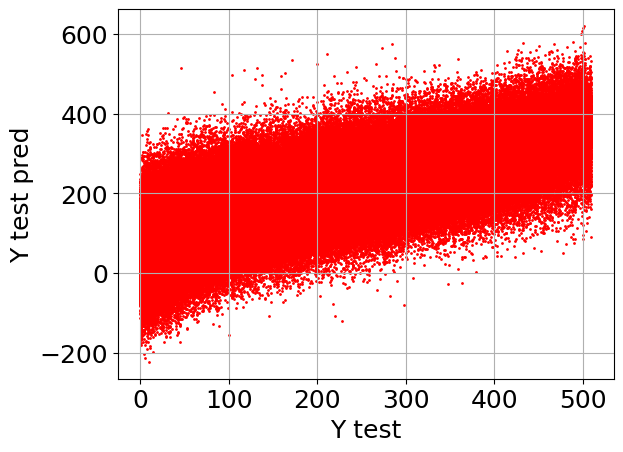

In [94]:
fig, ax = plt.subplots()
ax.scatter(Y_test, Y_test_pred,
        color='red',
        s=1
)

# plt.legend(loc='lower right', prop={'size': 16}, edgecolor='k')
plt.xlabel('Y test', fontsize=18)
plt.ylabel('Y test pred', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
# plt.xlim(left=0, right=1)
# plt.ylim(bottom=0.5, top=0.75)
# plt.yscale('log')
plt.grid()
plt.show()

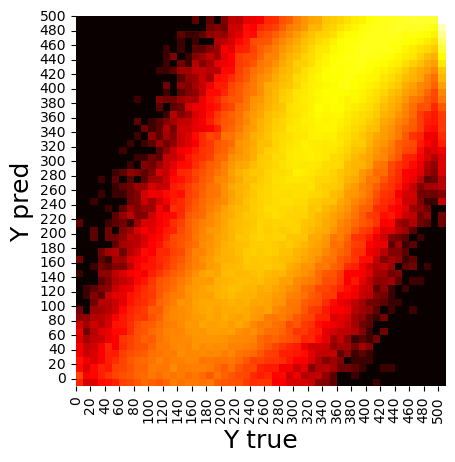

In [124]:
gridsize=10

Y_pred_capped = np.clip(
    Y_test_pred, a_min=np.amin(Y_test), a_max=np.amax(Y_test)
)
num_grid = int(np.ceil(np.amax(Y_test) / gridsize))
heat = np.zeros((num_grid, num_grid))

for pred, actual in zip(Y_pred_capped, Y_test):
    pred_idx = max(int(np.ceil(pred / gridsize)) - 1, 0)
    actual_idx = max(int(np.ceil(actual / gridsize)) - 1, 0)
    heat[actual_idx, num_grid - 1 - pred_idx] += 1

heat[heat != 0] = np.log(heat[heat != 0])
fig, ax = plt.subplots()
sns.heatmap(heat, ax=ax, square=True, cbar=False, cmap='hot')
ax.set_xticks(list(range(num_grid))[::2])
ax.set_xticklabels([i * gridsize for i in range(num_grid)][::2])
ax.set_xlabel('Y true', fontsize=18)
ax.set_yticks(list(range(num_grid))[::2])
ax.set_yticklabels([i * gridsize for i in range(num_grid)][::-2])
ax.set_ylabel('Y pred', fontsize=18)
plt.show()

In [55]:
train_r2 = lr.score(X_train, Y_train)
test_r2 = lr.score(X_test, Y_test)

print("train R2 {:.3f}, test R2 {:.3f}".format(train_r2, test_r2))

train R2 0.577, test R2 0.556


In [58]:
Y_test_pred = lr.predict(X_test)
test_mse, test_mae = mean_squared_error(Y_test, Y_test_pred), mean_absolute_error(Y_test, Y_test_pred)

print("Test MSE {:.5f}, MAE {:.5f}".format(test_mse, test_mae))

Test MSE 8006.59388, MAE 71.23355


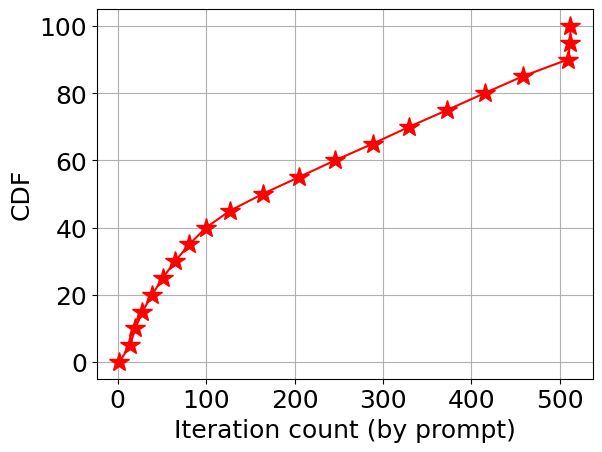

In [65]:
qlist = list(range(0, 105, 5))
iteration_counts = [r['iteration_count'] for r in records[1:]]
percentiles = np.percentile(iteration_counts, q=qlist)

fig, ax = plt.subplots()
ax.plot(percentiles, qlist,
        marker="*",
        markersize=15,
        markevery=1,
        color='red'
)

# plt.legend(loc='lower right', prop={'size': 16}, edgecolor='k')
plt.xlabel('Iteration count (by prompt)', fontsize=18)
plt.ylabel('CDF', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
# plt.xlim(left=0, right=1)
# plt.ylim(bottom=0.5, top=0.75)
# plt.yscale('log')
plt.grid()
plt.show()

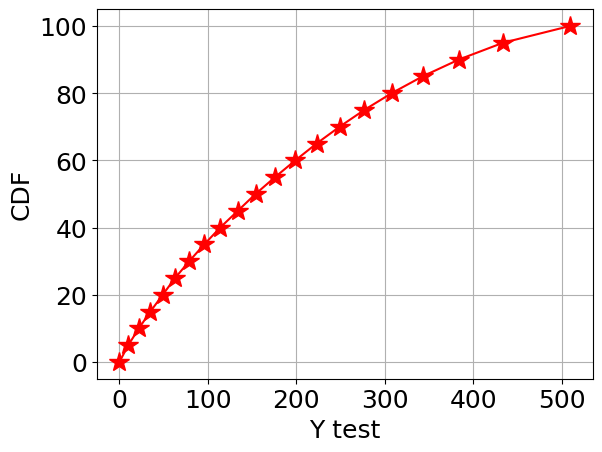

In [63]:
qlist = list(range(0, 105, 5))
percentiles = np.percentile(Y_test, q=qlist)

fig, ax = plt.subplots()
ax.plot(percentiles, qlist,
        marker="*",
        markersize=15,
        markevery=1,
        color='red'
)

# plt.legend(loc='lower right', prop={'size': 16}, edgecolor='k')
plt.xlabel('Y test', fontsize=18)
plt.ylabel('CDF', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
# plt.xlim(left=0, right=1)
# plt.ylim(bottom=0.5, top=0.75)
# plt.yscale('log')
plt.grid()
plt.show()

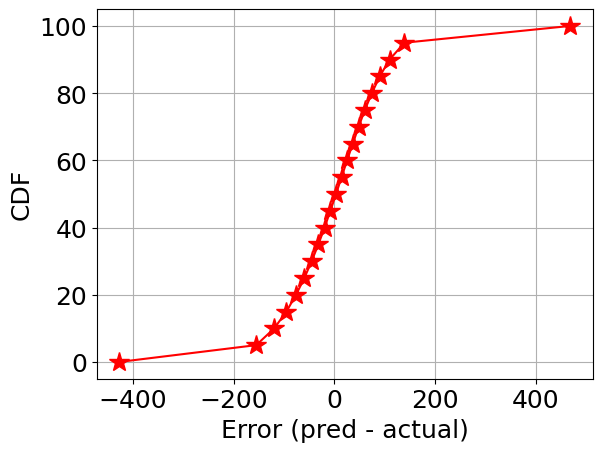

In [75]:
# Error distribution
error = Y_test_pred - Y_test

qlist = list(range(0, 105, 5))
percentiles = np.percentile(error, q=qlist)

fig, ax = plt.subplots()
ax.plot(percentiles, qlist,
        marker="*",
        markersize=15,
        markevery=1,
        color='red'
)

# plt.legend(loc='lower right', prop={'size': 16}, edgecolor='k')
plt.xlabel('Error (pred - actual)', fontsize=18)
plt.ylabel('CDF', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
# plt.xlim(left=0, right=1)
# plt.ylim(bottom=0.5, top=0.75)
# plt.yscale('log')
plt.grid()
plt.show()

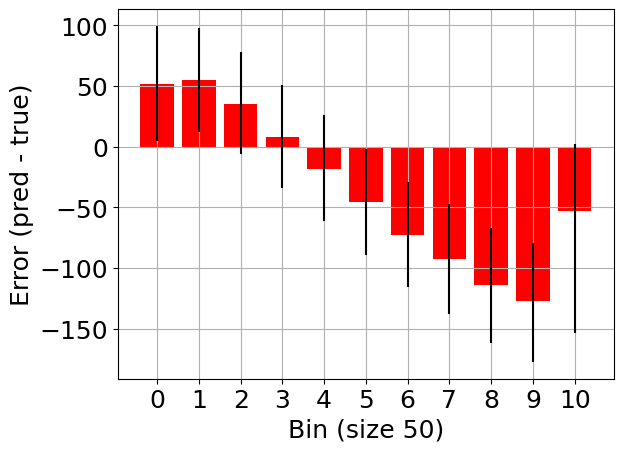

In [82]:
binsize = 50
num_bins = int(np.ceil(np.amax(Y_test) / binsize))
error_by_bin = [list() for _ in range(num_bins)]

for pred, actual in zip(Y_test_pred, Y_test):
    bin_idx = int(np.ceil(actual / binsize)) - 1
    error_by_bin[bin_idx].append(pred - actual)

err_median = np.array([np.median(x) for x in error_by_bin])
err_25 = np.array([np.percentile(x, q=25) for x in error_by_bin])
err_75 = np.array([np.percentile(x, q=75) for x in error_by_bin])

fig, ax = plt.subplots()
xvals = list(range(0, num_bins))
ax.bar(xvals, err_median,
    color='red',
    yerr=[err_median - err_25, err_75 - err_median]
)

# plt.legend(loc='lower right', prop={'size': 16}, edgecolor='k')
plt.xlabel(f'Bin (size {binsize})', fontsize=18)
plt.ylabel('Error (pred - true)', fontsize=18)
plt.xticks(xvals, fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
# plt.xlim(left=0, right=1)
# plt.ylim(bottom=0.5, top=0.75)
# plt.yscale('log')
plt.grid()
plt.show()

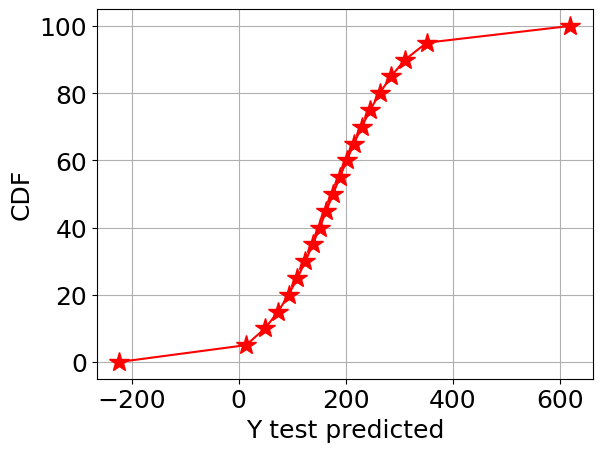

In [84]:
# plot prediction CDF
qlist = list(range(0, 105, 5))
percentiles = np.percentile(Y_test_pred, q=qlist)

fig, ax = plt.subplots()
ax.plot(percentiles, qlist,
        marker="*",
        markersize=15,
        markevery=1,
        color='red'
)

# plt.legend(loc='lower right', prop={'size': 16}, edgecolor='k')
plt.xlabel('Y test predicted', fontsize=18)
plt.ylabel('CDF', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
# plt.xlim(left=0, right=1)
# plt.ylim(bottom=0.5, top=0.75)
# plt.yscale('log')
plt.grid()
plt.show()

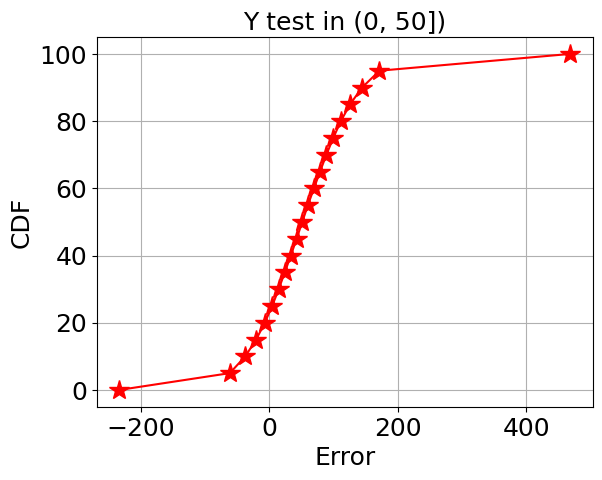

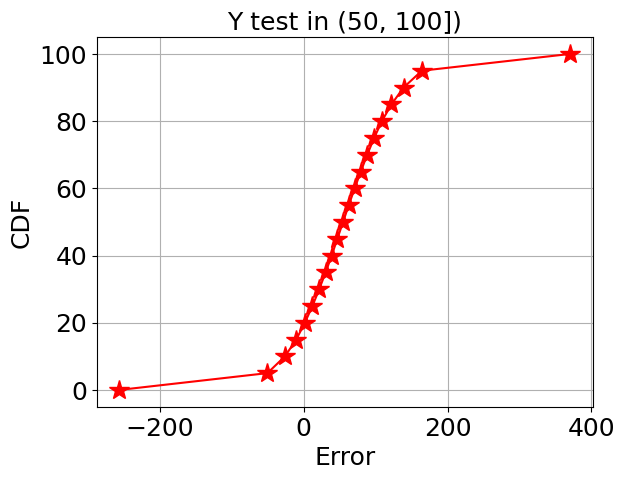

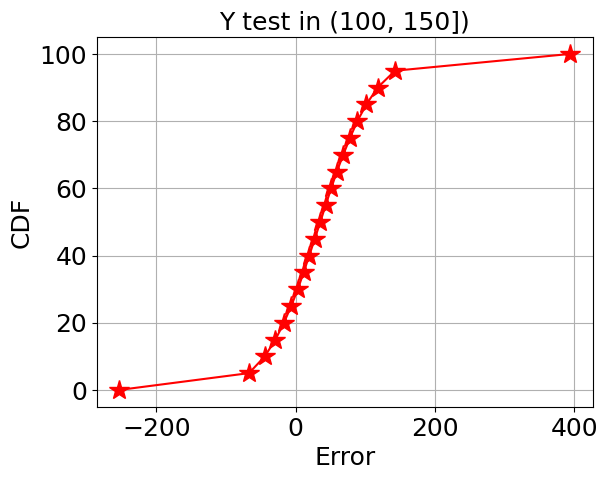

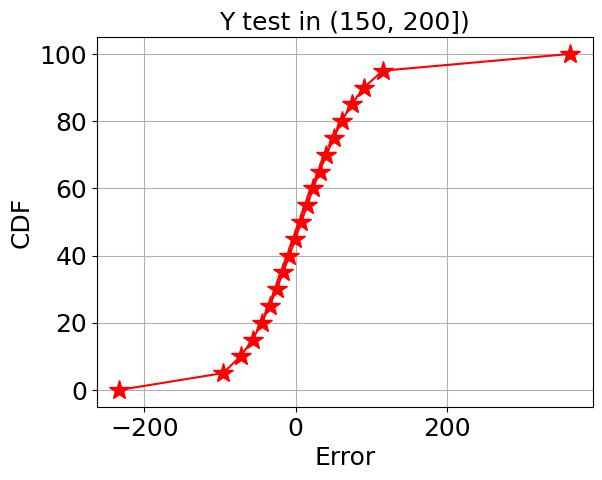

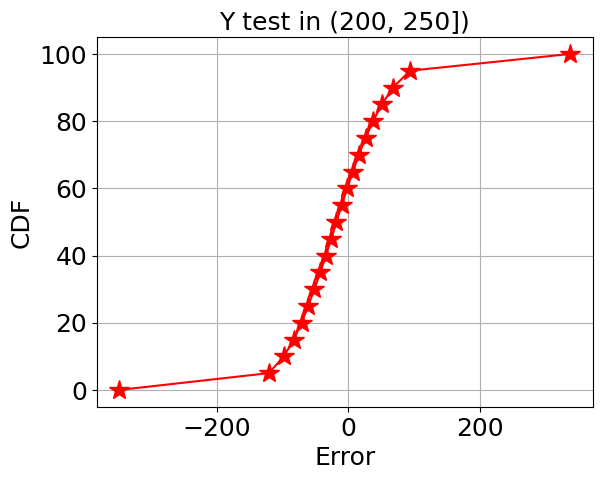

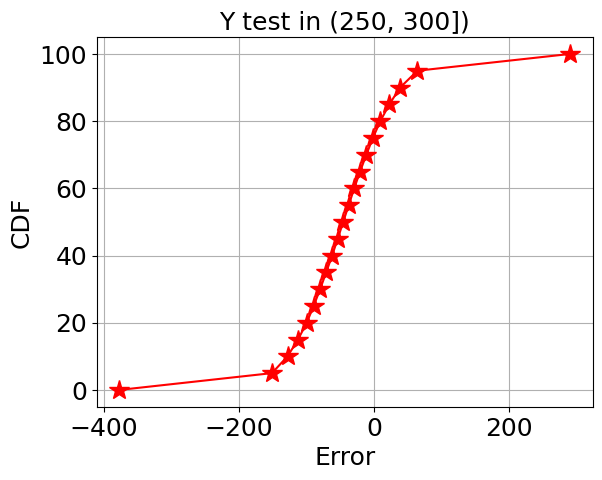

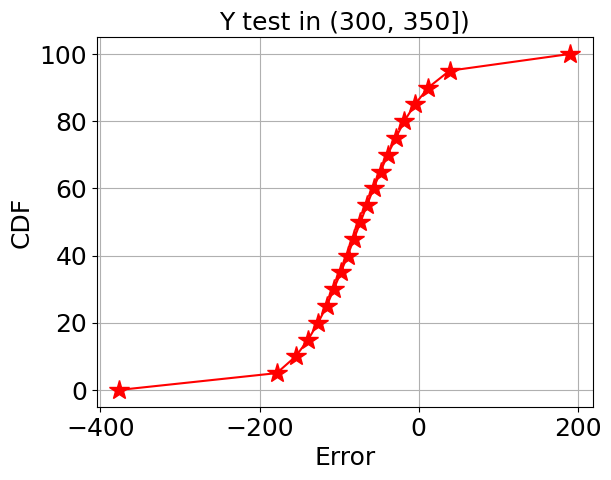

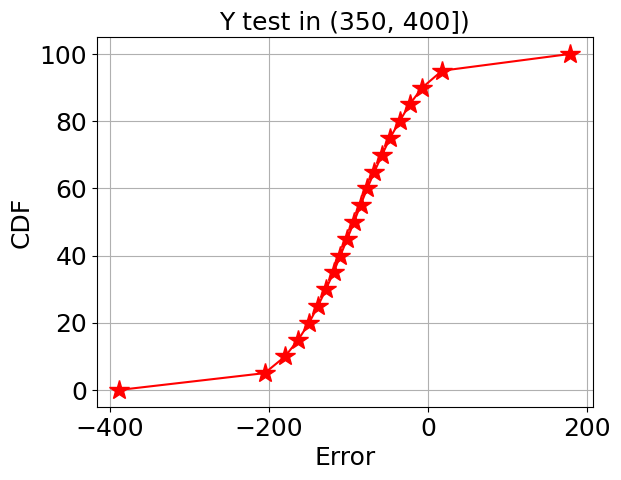

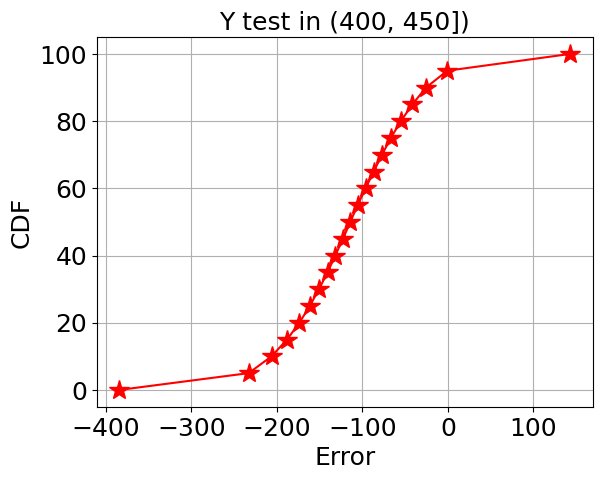

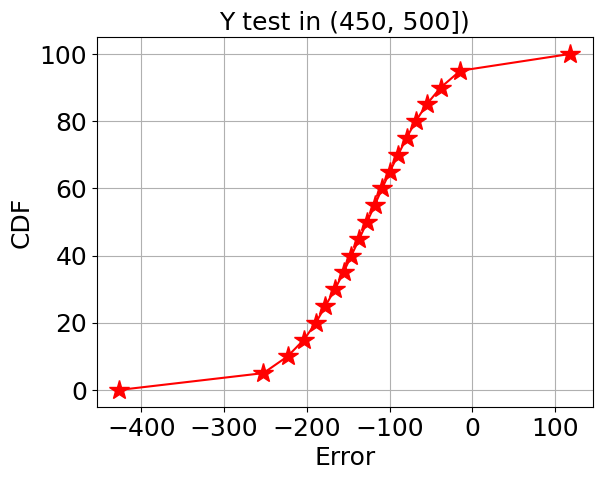

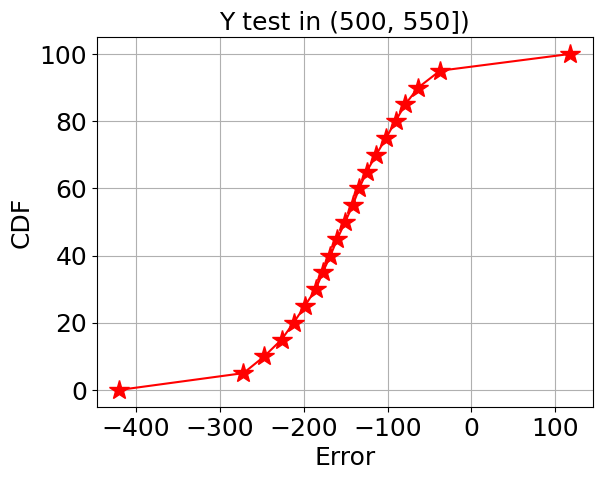

In [91]:
binsize = 50
num_bins = int(np.ceil(np.amax(Y_test) / binsize))
Y_test_np, Y_test_pred_np = np.array(Y_test), np.array(Y_test_pred)

for bin_idx in range(num_bins):
    lb = bin_idx * binsize
    ub = bin_idx * binsize + binsize
    mask = (Y_test_np > lb) & (Y_test_np <= ub)

    qlist = list(range(0, 105, 5))
    percentiles = np.percentile((Y_test_pred_np - Y_test_np)[mask], q=qlist)

    fig, ax = plt.subplots()
    ax.plot(percentiles, qlist,
        marker="*",
        markersize=15,
        markevery=1,
        color='red'
    )

    # plt.legend(loc='lower right', prop={'size': 16}, edgecolor='k')
    plt.title(f"Y test in ({lb}, {ub}])", fontsize=18)
    plt.xlabel('Error', fontsize=18)
    plt.ylabel('CDF', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    # plt.xlim(left=0, right=1)
    # plt.ylim(bottom=0.5, top=0.75)
    # plt.yscale('log')
    plt.grid()
    plt.show()

TODO:
- Check if error shrinks with more generations
    - Running average with previous predictions
- Special model for first-token embeddings (linear regression)
- Sequence of historical predictions ...
- Bootstrap to avoid bias on prompt length
- Binning and classification
    - Log scale bin sizes (?)
    - Probability at each range